# LSTM Model

In [197]:
#Load libraries
import pandas as pd
import numpy as np
from numpy import split
from numpy import array

from math import sqrt
import quandl
from functools import reduce
from matplotlib import pyplot as plt


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout,Activation, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae

In [136]:
#Load data
quandl.ApiConfig.api_key = "UqYbx-p5DwWzyT8AH2c7"
BTC_USD = quandl.get("BCHAIN/MKPRU")
BTC_USD.tail()

,Value
Date,
2020-06-08,9670.43
2020-06-09,9753.85
2020-06-10,9782.59
2020-06-11,9775.15
2020-06-12,9892.13


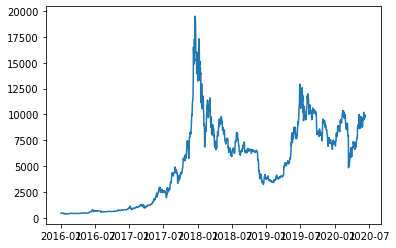

In [137]:
#EDA
btc_data=BTC_USD.loc[BTC_USD.index>"2016-01-01"]
plt.plot(btc_data)

(1460, 1)
(31, 1)


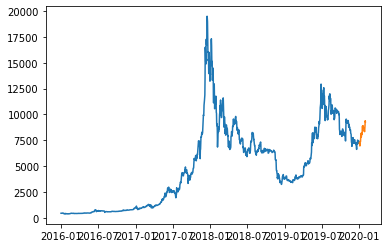

In [138]:
#Split
train= btc_data.loc["2016-01-01":"2019-12-31"]
test= btc_data.loc["2020-01-01":"2020-01-31"]
plt.plot(train)
plt.plot(test)
print(train.shape)
print(test.shape)

In [139]:
data = btc_data.loc["2016-01-01":"2020-01-31"]

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [162]:
supervised = series_to_supervised(data.values, 30, 30)
print(supervised.shape)
supervised.head()

(1432, 60)


,var1(t-30),var1(t-29),var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),...,var1(t+20),var1(t+21),var1(t+22),var1(t+23),var1(t+24),var1(t+25),var1(t+26),var1(t+27),var1(t+28),var1(t+29)
30,432.33,433.94,428.13,433.00,431.90,430.75,453.71,447.04,450.15,446.24,...,439.48,434.67,438.50,417.00,423.10,421.40,424.34,432.00,433.47,436.18
31,433.94,428.13,433.00,431.90,430.75,453.71,447.04,450.15,446.24,447.11,...,434.67,438.50,417.00,423.10,421.40,424.34,432.00,433.47,436.18,431.87
32,428.13,433.00,431.90,430.75,453.71,447.04,450.15,446.24,447.11,446.66,...,438.50,417.00,423.10,421.40,424.34,432.00,433.47,436.18,431.87,429.99
33,433.00,431.90,430.75,453.71,447.04,450.15,446.24,447.11,446.66,429.57,...,417.00,423.10,421.40,424.34,432.00,433.47,436.18,431.87,429.99,421.44
34,431.90,430.75,453.71,447.04,450.15,446.24,447.11,446.66,429.57,431.90,...,423.10,421.40,424.34,432.00,433.47,436.18,431.87,429.99,421.44,416.48


In [141]:
train=supervised[:1402]
test=supervised[1402:]
test.shape

(30, 60)

In [163]:
col_list = supervised.columns
x_col_list= col_list[:30]
y_col_list = col_list[30:]


train_x = np.array(train.loc[:,x_col_list])
train_x = train_x.reshape(1402,30,1)
train_y = np.array(train.loc[:,y_col_list])
train_y.shape

print (train_x.shape)
print (train_y.shape)

(1402, 30, 1)
(1402, 30)


In [164]:
test_x=np.array(test.loc[:,x_col_list])
test_x=test_x.reshape(30,30,1)
test_y=np.array(test.loc[:,y_col_list])

print (test_x.shape)
print (test_y.shape)

(30, 30, 1)
(30, 30)


## Vanilla LSTM

In [168]:
#Model 2 - Single LSTM with two fully connected layer 
model2 = Sequential()

model2.add(LSTM(400, input_shape=(30,1)))
model2.add(Dense(100))
model2.add(Dense(30))

model2.summary()
model2.compile (loss='mae', optimizer ='adam', metrics =['mae'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 400)               643200    
_________________________________________________________________
dense_10 (Dense)             (None, 100)               40100     
_________________________________________________________________
dense_11 (Dense)             (None, 30)                3030      
Total params: 686,330
Trainable params: 686,330
Non-trainable params: 0
_________________________________________________________________


In [169]:
esCallback = EarlyStopping(monitor='val_mae',
                           min_delta=0,
                           patience=3,
                           verbose=1,
                           mode='min')

In [170]:
yhistory2 = model2.fit( train_x, train_y, epochs=30, validation_data=(test_x,test_y),verbose=1,  callbacks=[esCallback])

Train on 1402 samples, validate on 30 samples
Epoch 1/30
 - 9s - loss: 4972.6539 - mae: 4972.6538 - val_loss: 7550.9937 - val_mae: 7550.9937
Epoch 2/30
 - 6s - loss: 4854.5779 - mae: 4854.5776 - val_loss: 7336.0562 - val_mae: 7336.0562
Epoch 3/30
 - 6s - loss: 4541.3222 - mae: 4541.3223 - val_loss: 6902.8638 - val_mae: 6902.8638
Epoch 4/30
 - 8s - loss: 4214.2593 - mae: 4214.2593 - val_loss: 6438.9307 - val_mae: 6438.9307
Epoch 5/30
 - 9s - loss: 3843.2966 - mae: 3843.2964 - val_loss: 5811.3501 - val_mae: 5811.3501
Epoch 6/30
 - 6s - loss: 3333.2408 - mae: 3333.2410 - val_loss: 4949.2812 - val_mae: 4949.2812
Epoch 7/30
 - 6s - loss: 2758.3136 - mae: 2758.3137 - val_loss: 3947.9573 - val_mae: 3947.9573
Epoch 8/30
 - 6s - loss: 2239.1058 - mae: 2239.1062 - val_loss: 3115.9814 - val_mae: 3115.9814
Epoch 9/30
 - 6s - loss: 1883.4716 - mae: 1883.4718 - val_loss: 2237.9905 - val_mae: 2237.9905
Epoch 10/30
 - 6s - loss: 1486.7209 - mae: 1486.7211 - val_loss: 1359.1617 - val_mae: 1359.1617
Epo

In [181]:
results2 = model2.predict(test_x[0].reshape(1,30,1))
results2.shape

(1, 30)

7.445335121208166
603.7931419270833


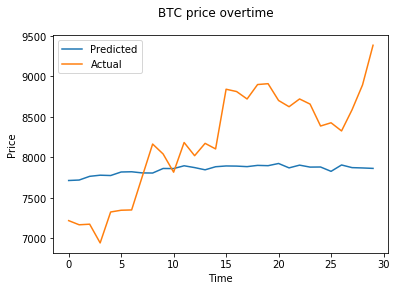

In [186]:
actual= np.array(btc_data.loc["2020-01-01":"2020-01-30"])
fig = plt.figure()
plt.plot(np.squeeze(results2),label="Predicted")
plt.plot(actual,label="Actual")
plt.legend(loc="upper left")
fig.suptitle('BTC price overtime')
plt.xlabel('Time')
plt.ylabel('Price')
actual = actual.reshape(1,30)
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 200 * np.mean(diff)

print(smape(actual,results2))
print(mae(actual,results2))

## Bidirectional LSTM

In [199]:
#Model 3 - Bidirectional LSTM with two fully connected layer 
model3 = Sequential()

model3.add(Bidirectional(LSTM(400),input_shape=(30,1)))
model3.add(Dense(100))
model3.add(Dense(30))

model3.summary()
model3.compile (loss='mae', optimizer ='adam', metrics =['mae'])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 800)               1286400   
_________________________________________________________________
dense_20 (Dense)             (None, 100)               80100     
_________________________________________________________________
dense_21 (Dense)             (None, 30)                3030      
Total params: 1,369,530
Trainable params: 1,369,530
Non-trainable params: 0
_________________________________________________________________


In [200]:
yhistory3 = model3.fit( train_x, train_y, epochs=50, validation_data=(test_x,test_y),verbose=1,  callbacks=[esCallback])
results3 = model3.predict(test_x[0].reshape(1,30,1))
results3.shape

Train on 1402 samples, validate on 30 samples
Epoch 1/50
1402/1402 [==============================] - 9s 6ms/step - loss: 4956.2549 - mae: 4956.2559 - val_loss: 7493.8804 - val_mae: 7493.8804
Epoch 2/50
1402/1402 [==============================] - 8s 5ms/step - loss: 4694.9356 - mae: 4694.9355 - val_loss: 7029.0093 - val_mae: 7029.0093
Epoch 3/50
1402/1402 [==============================] - 8s 6ms/step - loss: 4243.8340 - mae: 4243.8345 - val_loss: 6374.8823 - val_mae: 6374.8823
Epoch 4/50
1402/1402 [==============================] - 8s 6ms/step - loss: 3775.5605 - mae: 3775.5603 - val_loss: 5504.8101 - val_mae: 5504.8101
Epoch 5/50
1402/1402 [==============================] - 9s 6ms/step - loss: 3026.1732 - mae: 3026.1733 - val_loss: 4176.4058 - val_mae: 4176.4058
Epoch 6/50
1402/1402 [==============================] - 9s 6ms/step - loss: 2268.9823 - mae: 2268.9824 - val_loss: 2862.2661 - val_mae: 2862.2661
Epoch 7/50
1402/1402 [==============================] - 8s 6ms/step - loss: 17

(1, 30)

In [220]:
actual= np.array(btc_data.loc["2020-01-01":"2020-01-30"])
actual = actual.reshape(1,30)

print(smape(actual,results3))
print(mae(actual,results3))

13.165850387353354
1035.0118391927085


## S-LSTM

In [223]:
#Model 3 - Stacked LSTM with two fully connected layer 
model4 = Sequential()

model4.add(LSTM(400,input_shape=(30,1),return_sequences=True))
model4.add(LSTM(400))           
model4.add(Dense(100))
model4.add(Dense(30))

model4.summary()
model4.compile (loss='mae', optimizer ='adam', metrics =['mae'])

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 30, 400)           643200    
_________________________________________________________________
lstm_17 (LSTM)               (None, 400)               1281600   
_________________________________________________________________
dense_22 (Dense)             (None, 100)               40100     
_________________________________________________________________
dense_23 (Dense)             (None, 30)                3030      
Total params: 1,967,930
Trainable params: 1,967,930
Non-trainable params: 0
_________________________________________________________________


In [224]:
yhistory4 = model4.fit( train_x, train_y, epochs=50, validation_data=(test_x,test_y),verbose=1,  callbacks=[esCallback])
results4 = model4.predict(test_x[0].reshape(1,30,1))
results4.shape

Train on 1402 samples, validate on 30 samples
Epoch 1/50
1402/1402 [==============================] - 11s 8ms/step - loss: 4943.2452 - mae: 4943.2456 - val_loss: 7463.9790 - val_mae: 7463.9790
Epoch 2/50
1402/1402 [==============================] - 10s 7ms/step - loss: 4662.8878 - mae: 4662.8882 - val_loss: 7002.1040 - val_mae: 7002.1040
Epoch 3/50
1402/1402 [==============================] - 11s 8ms/step - loss: 4241.4032 - mae: 4241.4033 - val_loss: 6371.4688 - val_mae: 6371.4688
Epoch 4/50
1402/1402 [==============================] - 12s 9ms/step - loss: 3962.9960 - mae: 3962.9963 - val_loss: 5694.6250 - val_mae: 5694.6250
Epoch 5/50
1402/1402 [==============================] - 12s 8ms/step - loss: 3702.2255 - mae: 3702.2253 - val_loss: 4831.9053 - val_mae: 4831.9053
Epoch 6/50
1402/1402 [==============================] - 14s 10ms/step - loss: 3470.6779 - mae: 3470.6782 - val_loss: 3986.8621 - val_mae: 3986.8621
Epoch 7/50
1402/1402 [==============================] - 15s 11ms/step -

(1, 30)

In [225]:
actual= np.array(btc_data.loc["2020-01-01":"2020-01-30"])
actual = actual.reshape(1,30)

print(smape(actual,results4))
print(mae(actual,results4))

96.54299321668394
5345.444329101563
